# 0. Install and import packages

In [1]:
!pip install fake-useragent
!pip install beautifulsoup4
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
!pip install bs4
!pip install biopython

  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp36-none-any.whl size=13485 sha256=293054e8effdfe2d2ee788fb9a0716d838e72fdb96c9dfa8a03dbebaff1c3239
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
Successfully built fake-useragent
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/mai

In [2]:
import openpyxl
import requests
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium import webdriver
import re
import requests
from lxml import html
from lxml import etree
import urllib
import re   
import unicodedata
import time
from Bio import Entrez
import networkx as nx
import pandas as pd

What do you want to search?

In [3]:
myquery = '"radiomics"AND"CT"AND"Ovarian Cancer"'

# 1. Get excel with abstracts

Add your personal key and email here to be able to access the PubMed database

Instructions to get your personal key can be found here: https://ncbiinsights.ncbi.nlm.nih.gov/2017/11/02/new-api-keys-for-the-e-utilities/


In [4]:
Entrez.email = 'name@domain'


The api key is optional, but you can get more articles without error

In [ ]:
Entrez.api_key = "*********"

Some helper functions...

In [7]:
def search(query,mymax):
    handle = Entrez.esearch(db='pubmed', 
                            sort='relevance', 
                            retmax=str(mymax),
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    return results

def fetch_details(id_list):
    ids = ','.join(id_list)
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results

def fetch_details_2(id):
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=id)
    results = Entrez.read(handle)
    return results

Get the results

In [8]:
titles=[]
aims=[]
mms=[]
ress=[]
concs=[] 
refs=[]
abs=[]
pmids = []
cited_by = []

mymax=100
results = search(myquery,mymax)
id_list = results['IdList'] # list of UIDs
chunk_size = 50 # whatever you like   
for chunk_i in range(0, len(id_list), chunk_size):
    chunk = id_list[chunk_i:chunk_i + chunk_size]
 
    papers = fetch_details(chunk)
    for i, paper in enumerate(papers['PubmedArticle']):
      try:
          data = paper.get('PubmedData')
          data2 = paper.get('MedlineCitation')
          article = data2.get('Article')
          title = article.get('ArticleTitle')
          abstr = article.get('Abstract')
          abstr = abstr.get('AbstractText')
          ref = data.get('ReferenceList')
          refs.append(ref)
          pmids.append(data2.get('PMID'))
          cited_by.append('')
          try:
            aim = abstr[0]
            MM = abstr[1]
            res = abstr[2]
            conc = abstr[3]
            titles.append(title)
            aims.append(aim)
            mms.append(MM)
            ress.append(res)
            concs.append(conc)
            abs.append('')
          except:
            abs.append(abstr[0])
            titles.append(title)
            aims.append('')
            mms.append('')
            ress.append('')
            concs.append('')
      except:
          pass


add them to a dataframe and download!

In [9]:
data = {'title': titles, 'id':pmids,'abs':abs,'aims':aims,'MM':mms,'res':ress,'concl':concs} 
df2 = pd.DataFrame(data) 

In [10]:
df2

,title,id,abs,aims,MM,res,concl
0,Radiomics: a Novel CT-Based Method of Predicti...,30441264,In order to predict the 3-year recurrence of a...,,,,
1,Radiomics of high-grade serous ovarian cancer:...,29737390,,"To determine if radiomic features, alone or co...",This retrospective study enrolled 101 patients...,Patients with values of F2-Shape/Compactness1 ...,This study demonstrated significant associatio...
2,Integration of proteomics with CT-based qualit...,32253542,,To investigate the association between CT imag...,"This retrospective, hypothesis-generating stud...",Four proteins were associated with CT-based im...,This study provides the first insights into th...
3,Association between CT-texture-derived tumor h...,30474722,,To assess the associations between inter-site ...,Retrospective study of 88 HGSOC patients under...,Higher inter-site cluster variance (SCV) was a...,The assessment of tumoral heterogeneity in the...
4,Applying Quantitative CT Image Feature Analysi...,28554551,,The study aimed to investigate the role of app...,A dataset involving 91 patients was retrospect...,The highest areas under the receiver operating...,This study demonstrated the feasibility of pre...
5,A Computed Tomography-Based Radiomic Prognosti...,31024855,<b>Objectives:</b> We used radiomic analysis t...,,,,
6,Tissue-specific and interpretable sub-segmenta...,32421652,,Cancer typically exhibits genotypic and phenot...,With the goal of achieving the automated sub-s...,"On all tested sub-segmentation tasks, our two-...",The proposed intelligent framework could be re...
7,A novel representation of inter-site tumour he...,28289945,,To evaluate the associations between clinical ...,IRB-approved retrospective study of 38 HGSOC p...,Of the 12 inter-site texture heterogeneity met...,Quantitative metrics non-invasively capturing ...


In [ ]:
df2.to_excel('output.xlsx') 

# 2. Get the graph for the citations

Get the nodes and edges

In [11]:
nodes = []
edges = []
new_ids=[]
for i in range(len(refs)):
  temp = refs[i]
  name=str(pmids[i])
  if temp:
    if name not in nodes:
      nodes.append(name)
    temp2 = temp[0]
    A = temp2.get('Reference')
    for j in range(len(A)):
      temp3 = A[j].get('ArticleIdList')
      try:
        name2 = str(temp3[0])
        if name2 not in nodes:
          nodes.append(name2)
          new_ids.append(name2)

        edges.append((name,name2))
      except:
        pass

Build the graph

In [12]:
g = nx.Graph()
g.add_nodes_from(nodes)
for i in range(len(edges)):
  B = edges[i]
  g.add_edge(B[0], B[1])


color code the original papers in blue, the rest in red

In [13]:
color_map = []
for node in nodes:
    if node in pmids:
        color_map.append('blue')
    else: 
        color_map.append('red')      

get the graph

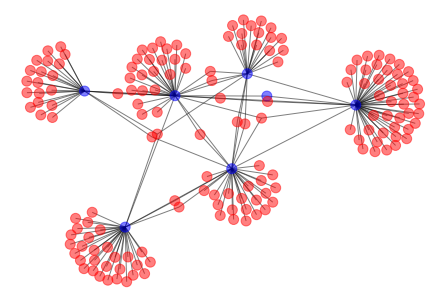

In [14]:
nx.draw(g,node_size=100, node_color=color_map,alpha=0.5)

Voilá!! 

now we can also get the abstracts for the references

In [15]:
mymax=100
id_list = new_ids # list of UIDs
chunk_size = 50 # whatever you like   
for chunk_i in range(0, len(id_list), chunk_size):
    chunk = id_list[chunk_i:chunk_i + chunk_size]
 
    papers = fetch_details(chunk)
    for i, paper in enumerate(papers['PubmedArticle']):
      try:
          data = paper.get('PubmedData')
          data2 = paper.get('MedlineCitation')
          article = data2.get('Article')
          title = article.get('ArticleTitle')
          abstr = article.get('Abstract')
          abstr = abstr.get('AbstractText')
          ref = data.get('ReferenceList')
          refs.append(ref)
          pmids.append(data2.get('PMID'))
          cited_by.append(str(g.degree(str(data2.get('PMID')))))
          try:
            aim = abstr[0]
            MM = abstr[1]
            res = abstr[2]
            conc = abstr[3]
            titles.append(title)
            aims.append(aim)
            mms.append(MM)
            ress.append(res)
            concs.append(conc)
            abs.append('')
          except:
            abs.append(abstr[0])
            titles.append(title)
            aims.append('')
            mms.append('')
            ress.append('')
            concs.append('')
      except:
          pass


add them to a dataframe

In [16]:
data = {'title': titles, 'id':pmids,'abs':abs,'aims':aims,'MM':mms,'res':ress,'concl':concs,'degree':cited_by} 
df2 = pd.DataFrame(data) 
df2

,title,id,abs,aims,MM,res,concl,degree
0,Radiomics: a Novel CT-Based Method of Predicti...,30441264,In order to predict the 3-year recurrence of a...,,,,,
1,Radiomics of high-grade serous ovarian cancer:...,29737390,,"To determine if radiomic features, alone or co...",This retrospective study enrolled 101 patients...,Patients with values of F2-Shape/Compactness1 ...,This study demonstrated significant associatio...,
2,Integration of proteomics with CT-based qualit...,32253542,,To investigate the association between CT imag...,"This retrospective, hypothesis-generating stud...",Four proteins were associated with CT-based im...,This study provides the first insights into th...,
3,Association between CT-texture-derived tumor h...,30474722,,To assess the associations between inter-site ...,Retrospective study of 88 HGSOC patients under...,Higher inter-site cluster variance (SCV) was a...,The assessment of tumoral heterogeneity in the...,
4,Applying Quantitative CT Image Feature Analysi...,28554551,,The study aimed to investigate the role of app...,A dataset involving 91 patients was retrospect...,The highest areas under the receiver operating...,This study demonstrated the feasibility of pre...,
...,...,...,...,...,...,...,...,...
166,Analysis of tumor specimens at the time of acq...,23470965,,All patients with EGF receptor (EGFR)-mutant l...,Patients with lung adenocarcinomas and acquire...,Adequate tumor samples for molecular analysis ...,This is the largest series reporting mechanism...,1
167,Histologic subtypes of ovarian carcinoma: an o...,18317227,Reproducible subclassification of ovarian carc...,,,,,1
168,Radiomics: the process and the challenges.,22898692,"""Radiomics"" refers to the extraction and analy...",,,,,1
169,Novel molecular subtypes of serous and endomet...,18698038,,The study aim to identify novel molecular subt...,Microarray gene expression profiling was done ...,Optimal clustering of array data identified si...,Gene expression profiling identified molecular...,1


and we can save/download the document 

In [ ]:
df2.to_excel('output.xlsx') 

Some of the posts I've used as references:

https://medium.com/@kliang933/scraping-big-data-from-public-research-repositories-e-g-pubmed-arxiv-2-488666f6f29b

https://github.com/CrossRef/rest-api-doc#queries
